In [1]:
import numpy as np
import matplotlib.pyplot as plt
import quadprog
import Classifier
import kernels
import challengeFunctions as cf


## check that the SVM work correctly

### Create dataset

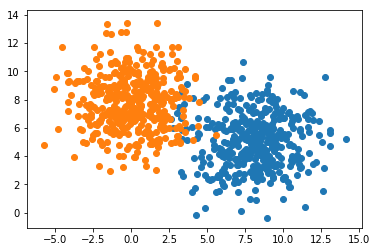

In [4]:
x1 = int(10*np.random.rand())
y1 = int(10*np.random.rand())
x2 = int(10*np.random.rand())
y2 = x1 = int(10*np.random.rand())
X11 = 2*np.random.randn(400) + x1
X12 = 2*np.random.randn(400) + y1

X21 = 2*np.random.randn(400) + x2
X22 = 2*np.random.randn(400) + y2
plt.figure()
plt.scatter(X11,X12)
plt.scatter(X21,X22)
plt.show()

In [5]:
X1 = np.vstack([X11, X12]).T# 100*np.ones(400)]).T
X2 = np.vstack([X21, X22]).T# 100*np.ones(400)]).T
Y =  np.hstack([np.ones(400), -np.ones(400)])
X = np.vstack([X1,X2])

### Define a display result fuction for different Kernels

In [6]:
def display_result(X,Y_true, svm):
    xmax = np.max(X[:,0])
    xmin = np.min(X[:,0])
    ymax = np.max(X[:,1])
    ymin = np.min(X[:,1])
    x = np.linspace(xmin, xmax, 10)
    y = np.linspace(ymin, ymax, 10)
    plt.figure()
    Xid, Y = np.meshgrid(x, y)
    Z = np.zeros((10,10))
    
    for kx in range(10):
        for ky in range(10) :
            
            Z[kx,ky] = svm.predict(np.array([[x[ky],y[kx]]]))
            
    plt.contourf(Xid, Y, Z, 20, cmap='RdGy')
    plt.colorbar()
    plt.contour(Xid, Y, Z, levels = 0,  colors='black')
    
    X1 = X[Y_true == 1]
    X2 = X[Y_true == -1]
    plt.scatter(X1[:,0],X1[:,1], c='red')
    plt.scatter(X2[:,0],X2[:,1], c= 'black')
    plt.show()
            
        
    

     pcost       dcost       gap    pres   dres
 0: -9.7559e+01 -9.1666e-01  5e+03  7e+01  4e-11
 1: -1.1134e+00 -9.1612e-01  5e+01  7e-01  4e-11
 2: -1.4311e-01 -8.6882e-01  3e+00  4e-02  2e-12
 3: -7.7377e-02 -4.7965e-01  7e-01  6e-03  3e-13
 4: -4.9954e-02 -1.6784e-01  2e-01  2e-03  9e-14
 5: -3.8674e-02 -8.2623e-02  8e-02  6e-04  4e-14
 6: -3.4940e-02 -6.2357e-02  5e-02  3e-04  3e-14
 7: -3.2517e-02 -4.9465e-02  3e-02  2e-04  2e-14
 8: -3.0988e-02 -3.9206e-02  1e-02  6e-05  2e-14
 9: -3.1319e-02 -3.3335e-02  3e-03  1e-05  2e-14
10: -3.1475e-02 -3.1806e-02  3e-04  1e-07  2e-14
11: -3.1558e-02 -3.1701e-02  1e-04  3e-08  2e-14
12: -3.1614e-02 -3.1635e-02  2e-05  3e-17  2e-14
13: -3.1624e-02 -3.1624e-02  3e-07  5e-18  2e-14
14: -3.1624e-02 -3.1624e-02  3e-09  1e-17  2e-14
Optimal solution found.
Number of non saturated constraints : 

60
score =  0.97875


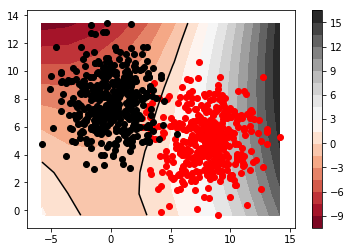

In [12]:
# learn classifier on the data

svm = Classifier.SVM("polynomial")
svm.lamb = 1
svm.train(X,Y)
Ytest = svm.predict(X)

# compute the score
pred = Ytest > 0
pred = 2*pred -1
score = np.sum(pred == Y)/800
print ('score = ', score)

#plot the decisison boundary
display_result(X, Y, svm)

## Test the Baseline

In [13]:
#first we try the baseline
def train_logreg(X,y):
    n = X.shape[0]
    p = X.shape[1]

    omega=np.zeros(p)

    while True:
        eta=1 / (1 + np.exp(np.clip(-X @ omega,-10,10)))

        D_eta=np.diag(eta*(1-eta))

        hessian = np.linalg.inv( X.T @ D_eta @ X )
        add = hessian @ X.T @ (y - eta)
        if np.sum(add >=1e-8) == 0:
            break
        omega = omega + add

    return omega

for i in range(1):
    Xf = np.genfromtxt('../data/Xtr{}_mat50.csv'.format(i))
    yf = np.genfromtxt('../data/Ytr{}.csv'.format(i),skip_header = 1,delimiter = ',')[:,1]
    omega = train_logreg(Xf,yf)

    y_pred = np.ones(Xf.shape[0])
    y_pred[Xf @ omega < 0] = 0
    print("Training accuracy : {}".format(cf.classification_accuracy(y_pred, yf))) 

Training accuracy : 0.644


In [14]:
X = cf.extractdata('../data/Xtr0_mat50.csv', sep = ' ')
Y = cf.extractdata('../data/Ytr0.csv')[1:,1]
Y = Y.astype(int)

In [15]:
Xtrain, Y_train, Xtest, Y_test = cf.splitdata(X,Y)
Xftrain, Yf_train, Xftest, Yf_test = cf.splitdata(Xf,yf)

In [16]:

omega = train_logreg(Xftrain,Yf_train)

y_pred = np.ones(Xftest.shape[0])
y_pred[Xftest @ omega < 0] = 0
print("Training accuracy : {}".format(cf.classification_accuracy(Yf_test, y_pred)))

Training accuracy : 0.616


In [31]:
train_acc = []
test_acc = []
lambs = [1e-8,1e-7,1e-6,1e-5]
for lamb in lambs:
    svm = Classifier.SVM("linear")
    svm.lamb = lamb

    Y_train_svm = 2*(Y_train - 1/2)
    Y_test_svm = 2*(Y_test - 1/2)
    svm.train(Xtrain, Y_train_svm)
    y_pred = svm.predict(Xtrain)
    y_pred = y_pred > 0
    train_acc.append(cf.classification_accuracy(Y_train, y_pred))
    y_pred = svm.predict(Xtest)
    y_pred = y_pred > 0
    test_acc.append(cf.classification_accuracy(Y_test, y_pred))



     pcost       dcost       gap    pres   dres
 0:  6.0286e+09 -3.1088e+11  3e+11  3e-10  3e-11
 1:  1.3684e+09 -3.1469e+10  3e+10  2e-10  1e-11
 2:  2.9805e+07 -3.1223e+09  3e+09  8e-10  1e-11
 3: -2.2476e+07 -1.3104e+08  1e+08  6e-10  1e-11
 4: -2.8176e+07 -5.1815e+07  2e+07  1e-09  1e-11
 5: -3.2173e+07 -4.8519e+07  2e+07  3e-10  1e-11
 6: -3.5918e+07 -4.4342e+07  8e+06  7e-10  1e-11
 7: -3.7638e+07 -4.2518e+07  5e+06  1e-09  1e-11
 8: -3.8901e+07 -4.1176e+07  2e+06  1e-09  2e-11
 9: -3.9484e+07 -4.0559e+07  1e+06  1e-09  2e-11
10: -3.9786e+07 -4.0235e+07  4e+05  1e-10  2e-11
11: -3.9921e+07 -4.0088e+07  2e+05  3e-10  2e-11
12: -3.9975e+07 -4.0029e+07  5e+04  1e-09  2e-11
13: -3.9992e+07 -4.0011e+07  2e+04  1e-09  2e-11
14: -3.9999e+07 -4.0004e+07  5e+03  1e-09  2e-11
15: -4.0001e+07 -4.0002e+07  1e+03  5e-10  2e-11
16: -4.0001e+07 -4.0001e+07  3e+02  5e-11  2e-11
17: -4.0001e+07 -4.0001e+07  6e+01  2e-16  2e-11
18: -4.0001e+07 -4.0001e+07  9e-01  1e-09  2e-11
Optimal solution foun

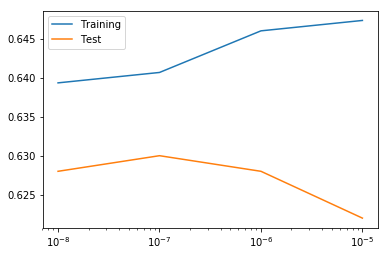

In [32]:
plt.semilogx(lambs,train_acc)
plt.semilogx(lambs,test_acc)
plt.legend(["Training",'Test'])
plt.show()